In [172]:
import torch
import numpy as np
from torch import nn, einsum
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import sys
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange
from random import random
from datasets import load_dataset
import os
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader

In [2]:
### WORK LOG ###

# this notebook is to try out an RIN arch for text.
# plan is to begin by adapting the main layers and training code from
# lucid rain's existing rin codebase for images. There are 2 things, in major
# to change: one is the embeddings at the interface input and the second is 
# tokenization. Tokenization can be tinkered with later on. We first
# begin by just trying out token embeddings instead of patch embeddings at
# interface input.

# the way the arch works is that we give token embeddings corrupted with
# gaussian noise as input, and pass it through a series of read-compute-write
# blocks and ultimately try to reconstruct the uncorrupted input.

# using sinusoidal embeddings for timesteps from Diffusion-LM. RIN has a module
# for the same too, but I believe it would be better to go with something that
# has worked with language before. They seem to be doing similar things, regardless.
# I have ported RIN one too, just in case.

# RIN uses a custom LN module without bias, saying it is more stable. 
# I am going to use the standard one from torch.

## NOTE ON PATCH SIZE AND NUMBER OF PATCHES
# (b, c, h, w) = (b, 3, 128, 128) => (b, (16*16), (3*8*8)) = [b, 256, 192]
# imagine an image with 3 channels, and each channel is an image of 128X128. 
# For each channel image, we want to divide it into 256 patches, each of size 8X8.
# You can also think about creating patches of the entire image, with the channels all 
# combined. 
# So we technically get 256 patches in total, each of size 8X8X3. So each patch is
# an embedding of dim 192.

### RIN block code flow
# input: patches=[bs, num_patches, dim], latents=[bs, num_latents, latent_dim], time_embedding=[bs, time_dim]
# num_patches = patch_h X patch_w
# In terms of its similarity with tensors for text sequences, you can think 
# of the 2nd dimesnion being seq_len for both patches and latents (which it actually is).
# The 2nd dim in patches is ph*pw => num_patches, and num_latents in latents.
# So the transformation from patches to latents involves compressing information
# along 2 axes, one across the sequence length (number of tokens) and the second 
# across the dimensionality of each token embedding. In this running example, we're only
# compressing across the first dimension and expanding across the second dimension
# (which kind of does not make sense lol). 
# 1. apply PEG layer (performs a 2d conv on the patches). No shape changes overall and would be irrelevant for text.
# 2. apply cross attention to project patches to latent space. Layer name is `latent_attends_to_patches`. 
# 3. apply ffn on cross attn output in latent space
# Note: in both 2 and 3, time_embedding is also passed. It's handled in different ways (not going into detail here).
# 4. loop in `latent_self_attns` which is a nn module list of Attention and FF layers.
#    apply attn and ff for each layer and add the residuals
# 5. an additional layer of self attention is applied. The layer is different (LinearAttention). Check.
# 6. apply cross attention from latent space to patches
# 7. apply ff in patch space, apply norm and return the final tensor.

## ATTENTION LAYER CODE FLOW (cross attention) ##
# input: latents = [bs, num_latents, latent_dim], patches = [bs, num_patches, dim], time = [bs, time_dim]
# 1. apply LN on patches
# 2. apply LN on latents
# 3. apply a sequential module on time input which consists of SiLU => Linear() => Rearrange(). 
#    The linear layer does not change the dimension of the vector. Rearrange adds an additional dimension at 1st index position
#    making the shape [bs, 1, time_dim]. The output of this layer is chunked across the last dimension into 2 tensors of
#    [bs, 1, time_dim//2]. The 2 tensors are called scale and shift. Not sure what they represent.
# 4. applied to latents: x = x*scale + shift.
# 5. 2 linear layers are defined to convert the inputs to relevant query and key values. For cross attention, latents are used
#    as queries and the patches are used as key and values. The projection of patches to kv is fused. (not sure how different this 
#    is than normal way of doing this projection separately.). First get q values by mapping latents and then kv. Dimensions of q,k,v are
#    head_dim*num_heads=model_dim. 
#    This operation gives q of shape [bs, num_latents, model_dim] and kv of shape [bs, num_patches, model_dim].
# 6. Reshape it to [bs, num_heads, num_latents (or num_patches), head_dim]. num_patches = num_latents.
# 7. In attend func: first mask if necessary (check since does not seem to happen in the image codebase).
# 8. Calculate similarity by multiplying q and k. Result is [bs, heads, num_latents, num_patches].
# 9. Multiply it by scale (model_dim ** -0.5).
# 10. Take softmax across last dim + dropout.
# 11. Multiply by v of shape [bs, heads, num_patches, head_dim] to get => [bs, heads, num_latents, head_dim].
# 12. Finally dim out to project it back to latent dim.


### NOTE ON ATTENTION vs LINEARATTENTION ###
# LinearAttention module is an efficient version of quadratic attention where k and v are multiplied first and the result is
# multiplied with q. Softmax is applied before taking products at relevant places. The overall result stands because it can be derived
# as a low rank approximation for the quadratic attention. 
# I can port it for now, but initially we can choose to just use the normal quadratic attention. I am also not sure how helpful linear
# attention is when applied to latents. As it is latents are the compressed version of the actual interface tokens. Per my understanding, it
# would make more sense to use it for longer sequences. Perhaps its more common in image datasets with high resolution data points.

# TODO: read more about `latent_token_time_cond` flag, what it signifies and the literature around it.
# TODO: understand what learned sinusoidal pos embedding does.


### FFN CODE FLOW ###
# 1. Apply LN on input x.
# 2. If time_cond_dim is passed in the initialization, add that information to the input by applying a net with SiLU() + Linear() + Rearrange().
#    The output is chunked across the last dim to get scale and shift. Then x = x * scale + shift. 
# 3. Linear() + GeLU() + Linear() is applied where first linear projects it to dim*4, and the final linear projects it back to dim.


### PLANNING ###
# (read/understand individual modules and adapt them for text)
# Read Attention and LinearAttention modules, figure out which is needed. 
# Rewrite the classes with more favorable naming.
# Rewrite FFN.
# Note how LN is used in text models (diffusion-lm) and use it in that way over here instead of using the image conventions.
# Rewrite RINBlock and stitch all the previous layers
# Rewrite RIN with previous layers. 

In [3]:
def timestep_embedding(timesteps, dim, max_period=10000):
    # timesteps = [bs]
    # dim = 128
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    # 64
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    # exp{-(T * t)/64}, where T is the time period, t is the current time instant
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        # TODO: why cating zeros?
    return embedding

In [4]:
emb = timestep_embedding(torch.arange(32), dim=128)
emb.shape

torch.Size([32, 128])

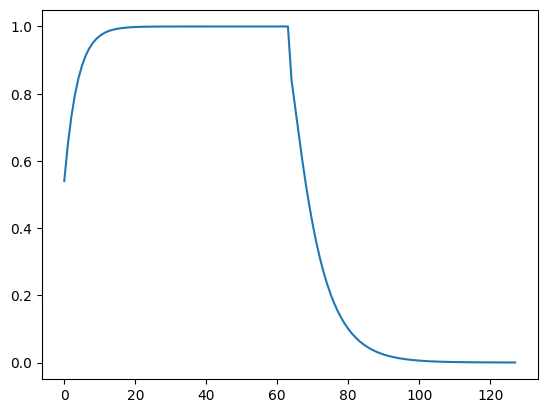

In [5]:
plt.plot(emb[1].tolist())

In [6]:
class LearnedSinusoidalPosEmb(nn.Module): # used in RIN (image modality)
    def __init__(self, dim):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

In [7]:
emb = LearnedSinusoidalPosEmb(128)
# plt.plot(emb.forward(torch.arange(32))[1].tolist())

# the embedding graph does not look as structured as the previous most likely
# because this is a learnable embedding unlike the previous one.

In [8]:
class Attention(nn.Module):
    def __init__(
        self,
        output_dim:int, # the expected output dimensionality after cross attention (query dimensionality)
        context_dim:int, # dimensionality of the current stream of computation (kv dimensionality)
        num_heads:int,
        head_dim:int,
        time_dim:int,
        attn_dropout:float,
        input_norm:bool,
        context_norm:bool,
        qk_norm:bool
    ):

        super().__init__()
        
        attn_dim = head_dim * num_heads
        self.scale = head_dim ** -0.5
        self.num_heads = num_heads
        self.attn_dropout = attn_dropout
        
        if context_dim is None:
            context_dim = output_dim
        
        if time_dim is not None:
            self.time_mlp = nn.Sequential(
                nn.GELU(),
                nn.Linear(time_dim, output_dim*2),
                Rearrange('b d -> b 1 d')
            )

            # TODO: does this make sense for text?
            nn.init.zeros_(self.time_mlp[-2].weight)
            nn.init.zeros_(self.time_mlp[-2].bias)

        # TODO: needed for text?
        self.input_ln = nn.LayerNorm(output_dim) if input_norm else nn.Identity()
        self.context_ln = nn.LayerNorm(context_dim) if context_norm else nn.Identity()

        self.to_q = nn.Linear(output_dim, attn_dim, bias=False)
        # TODO: how is this different than separately projecting k and v
        self.to_kv = nn.Linear(context_dim, attn_dim*2, bias=False)
        self.to_out = nn.Linear(attn_dim, output_dim, bias=False)

    def attend(self, q, k, v, mask=None):
        sim = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale
        # attention score is the amount of attention query token pays to the key token at any position.
        # So when the multiplication for q and k is a high value, it means that the latent (q) at that
        # position is looking for information that interface (k) had. Basically greater the similarity content
        # between the latents and the interface, greater the attn probability.
        
        if mask is not None: # TODO: check if we need masking
            sim = sim.masked_fill(~mask, -torch.finfo(sim.dtype).max)

        attn = sim.softmax(dim=-1)
        attn = F.dropout(attn, p=self.attn_dropout)
        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        return out
        

    def forward(
        self,
        inp,
        context,
        time
    ):
        # for interface to latents cross attn: inp=latents, context=interface
        # for latents to interface cross attn: inp=interface, context=latents
        # inp/context = [bs, num_interface_tokens, interface_dim] or [bs, num_latents, latent_dim]
        # time = [bs]
        
        h = self.num_heads
        if context is not None:
            context = self.context_ln(context)

        inp = self.input_ln(inp)
        if context is None:
            context = inp

        ## TODO: check if this is correct. The time input we're receiving here is already passed through
        # a time_mlp layer + latent concatenation in RIN module. We're doing the same computation here again 
        # before chunking the result into scale and shift. Possible that the goal is process the latent and time
        # embedding combined together.
        scale, shift = self.time_mlp(time).chunk(2, dim=-1)
        inp = (inp * (scale + 1)) + shift
        # Not sure what this is

        qkv = (self.to_q(inp), *self.to_kv(context).chunk(2, dim=-1))
        # qkv is a tuple of transformed q, k and v each of shape [bs, seq_len, attn_dim]
        # attn_dim=head_dim*num_heads

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        # [bs, seq_len, attn_dim] => [bs, num_heads, seq_len, head_dim]
        # seq_len = num_latents or num_interfaces

        out = self.attend(q, k, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)        

In [9]:
def test_attention_module():
    attn = Attention(512, 256, 4, 32, 1024, 0.2, True, True, True)
    
    inp = torch.randn(32, 128, 512)
    context = torch.randn(32, 256, 256)
    time = torch.randn(32, 1024)
    attn_out = attn(inp, context, time)
    assert attn_out.shape == torch.randn(32, 128, 512).shape

test_attention_module()

In [10]:
class FeedForwardLayer(nn.Module):
    def __init__(
        self,
        input_dim:int,
        mult_factor:int,
    ):
        super().__init__()
        self.time_cond = None
        self.norm = nn.LayerNorm(input_dim)
        if self.time_cond is not None:
            self.time_mlp = nn.Sequential(
                nn.GELU(),
                nn.Linear(time_dim, input_dim*2),
                Rearrange("b d -> b 1 d")
            )
            nn.init.zeros_(self.time_mlp[-2].weight)
            nn.init.zeros_(self.time_mlp[-2].bias)

        inner_dim = input_dim*mult_factor
        self.ffn = nn.Sequential(
            nn.Linear(input_dim, inner_dim),
            nn.GELU(),
            nn.Linear(inner_dim, input_dim)
        )

    def forward(self, x, time=None):

        x = self.norm(x)
        if self.time_cond is not None:
            scale, shift = self.time_mlp(time).chunk(2, dim=-1)
            x = (x*(scale+1)) + shift

        return self.ffn(x)       

In [11]:
## NOTE: time_dim or time_cond_dim is not passed to FF layers in the image codebase.
# It's only passed to attention layers as attn_kwargs.
def test_ffn_module():
    ffn = FeedForwardLayer(256, 4)
    inp = torch.randn(32, 128, 256)
    time = torch.ones(32, 1024)
    ffn_out = ffn(inp)
    assert ffn_out.shape == torch.randn(32, 128, 256).shape

test_ffn_module()

In [12]:
class RINBlock(nn.Module):
    def __init__(
        self,
        config,
        interface_dim:int,
        num_latent_attn_layers:int,
        latent_dim:int,
        time_dim:int,
        final_norm:bool
    ):
        super().__init__()

        attn_kwargs = {
            "num_heads": config.num_heads,
            "head_dim": config.head_dim,
            "time_dim": config.time_dim,
            "attn_dropout": config.attn_dropout,
            "input_norm": config.input_norm,
            "context_norm": config.context_norm,
            "qk_norm": config.qk_norm
        }
        self.interface_to_latents_cross_attn = Attention(
            output_dim=latent_dim,
            context_dim=interface_dim,
            **attn_kwargs
        )

        self.latents_ffn = FeedForwardLayer(
            input_dim=latent_dim,
            mult_factor=config.mult_factor
        )

        self.latent_self_attn_layers = nn.ModuleList([])
        for _ in range(num_latent_attn_layers):
            self.latent_self_attn_layers.append(
                nn.ModuleList([
                    Attention(
                        output_dim=latent_dim,
                        context_dim=None,
                        **attn_kwargs
                    ),
                    FeedForwardLayer(
                        input_dim=latent_dim,
                        mult_factor=config.mult_factor
                    )
                ])
            )

        self.latent_final_norm = nn.LayerNorm(latent_dim) if final_norm else nn.Identity()
        self.latents_to_interface_cross_attn = Attention(
            output_dim=interface_dim,
            context_dim=latent_dim,
            **attn_kwargs
        )
        self.interface_ffn = FeedForwardLayer(
            input_dim=interface_dim,
            mult_factor=config.mult_factor
        )

    def forward(
        self,
        interface,
        latents,
        time
    ):
        # latents = [bs, num_latents, latent_dim] (latent stream)
        # interface = [bs, num_interfaces, interface_dim] (input stream)
        # time = [bs, time_dim]
        # note that num_latents and num_interfaces are just seq_len dimensions.
        # We get some initiliazed latents and interface already to add to 
        # our subsequent computations.
        
        latents = self.interface_to_latents_cross_attn(latents, interface, time) + latents
        latents = self.latents_ffn(latents, time) + latents
        
        for attn, ffn in self.latent_self_attn_layers:
            latents = attn(latents, latents, time=time) + latents
            latents = ffn(latents, time) + latents
        
        interface = self.latents_to_interface_cross_attn(interface, latents, time) + interface
        interface = self.interface_ffn(interface, time) + interface
        # TODO: what initialized interface values are being used here?

        latents = self.latent_final_norm(latents)
        
        return interface, latents


In [13]:
class Config:
    def __init__(
        self,
        num_heads,
        head_dim,
        time_dim,
        attn_dropout,
        mult_factor,
        input_norm,
        context_norm,
        qk_norm
    ):
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.time_dim = time_dim
        self.attn_dropout = attn_dropout
        self.mult_factor = mult_factor
        self.input_norm = input_norm
        self.context_norm = context_norm
        self.qk_norm = qk_norm
        

In [14]:
def test_rin_block_module():
    config = Config(num_heads=4,head_dim=32,time_dim=1024,attn_dropout=0.4,mult_factor=4,input_norm=True,context_norm=True,qk_norm=True)   
    rinblock = RINBlock(config, 256, 4, 512, 1024, True)
    interface = torch.randn(32, 256, 256)
    latents = torch.randn(32, 128, 512)
    time = torch.randn(32, 1024)
    interface, latents = rinblock(interface, latents, time)
    assert interface.shape == torch.randn(32, 256, 256).shape
    assert latents.shape == torch.randn(32, 128, 512).shape

test_rin_block_module()

In [15]:
# Instead of code related to patches, we need to have something related to text.
# the process of converting image to patches and then to patch embedding needs to be replaced
# by something like word embeddings. 
# This could be byte embeddings or word embeddings (sub-word) to begin with.

# TODO:
# We don't have any positional embedding for tokens either at latent or interface level. 
# Mostly we need that. The sinusoidal positional embedding is only applied to time.

class RIN(nn.Module): ### WIP ###
    def __init__(
        self,
        config,
        interface_dim:int,
        num_rin_blocks:int,
        num_latent_attn_layers:int,
        vocab_size:int,
        interface_emb_dim:int, # embedding size of words in interface
        latent_dim:int,
        num_latents:int,
        learned_sinusoidal_dim:int, # TODO: check if needed
        latent_token_time_cond:bool,        
    ):
        super().__init__()
        self.latent_token_time_cond = latent_token_time_cond
        self.interface_embedding = nn.Embedding(vocab_size, interface_emb_dim)

        sinusoidal_pos_embedding = LearnedSinusoidalPosEmb(learned_sinusoidal_dim)
        time_dim = interface_dim*4
        fourier_dim = learned_sinusoidal_dim + 1
        self.time_mlp = nn.Sequential(
            sinusoidal_pos_embedding,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        self.latents = nn.Parameter(torch.randn(num_latents, latent_dim))
        nn.init.normal_(self.latents, std=0.02)
        self.initial_latents = nn.Sequential(
            FeedForwardLayer(latent_dim, 4),
            nn.LayerNorm(latent_dim)
        )
        #nn.init.zeros_(self.initial_latents[-1].gamma)

        self.rin_blocks = nn.ModuleList([
            RINBlock(
                config,
                interface_dim,
                num_latent_attn_layers,
                latent_dim,
                time_dim,
                True
            ) for _ in range(num_rin_blocks)
        ])
        self.unembed = nn.Linear(interface_dim, vocab_size)
        # TODO: check if this should be tied to embedding weight

    def forward(self, xt, time, input_self_cond, latent_self_cond, return_latents):
        # check if input_self_cond (input self conditioning - at interface) is done. 
        # I only remember it being done for latents. Not adding code for that right now.
        batch_size = xt.shape[0]
        time_emb = self.time_mlp(time)
        # [bs, time_dim] (time_dim = latent_dim*2)
        # [bs, 1024]

        latents = repeat(self.latents, 'n d -> b n d', b=batch_size)
        # [bs, num_latents, latent_dim]
        if latent_self_cond is not None:
            latents = latents + self.initial_latents(latent_self_cond)
            # [bs, 128, 512]

        # TODO: not sure about the theory behind this. Just copied for now. Check if needed.
        if self.latent_token_time_cond:
            # whether the time conditioning is to be treated as one latent token or for 
            # projecting into scale and shift for adaptive layernorm
            time_emb = rearrange(time_emb, 'b d -> b 1 d')
            latents = torch.cat([latents, time_emb], dim=-2)
            # [bs, 1, 1024] cat [bs, 128, 512] ==> [bs, 128, 1536]
            # time_emb and latents do not have the same size at -2 dim. 

        #interface_emb = self.interface_embedding(input_tokens)
        # [bs, num_interface_tokens, interface_dim] = [bs, seqlen, 256]
        # TODO: add positional embedding for tokens

        for rin_block in self.rin_blocks:
            interface, latents = rin_block(xt, latents, time_emb)
            # [bs, num_interfaces, interface_dim], [bs, num_latents, latent_dim]

        out = self.unembed(interface)
        # [bs, seq_len, vocab_size]
        # need to take softmax to get the predicted tokens

        return interface, out, latents

In [16]:
def test_rin_module():
    config = Config(num_heads=4,head_dim=32,time_dim=1024,attn_dropout=0.4,mult_factor=4,input_norm=True,context_norm=True,qk_norm=True)   
    rin = RIN(config,interface_dim=256,num_rin_blocks=4,num_latent_attn_layers=4,vocab_size=10000,interface_emb_dim=256,
              latent_dim=512,num_latents=128,learned_sinusoidal_dim=16,latent_token_time_cond=False)
    xt = torch.randn(32, 128, 256)
    time = torch.ones(32).long()
    interface, out, latents = rin(xt, time, True, None, True)
    assert interface.shape == torch.randn(32, 128, 256).shape
    assert out.shape == torch.randn(32, 128, 10000).shape
    assert latents.shape == torch.randn(32, 128, 512).shape

test_rin_module()

In [17]:

## Porting from image codebase, have not understood them yet. Might plot later if needed to understand.
def simple_linear_schedule(t, clip_min = 1e-9):
    return (1 - t).clamp(min = clip_min)

def cosine_schedule(t, start = 0, end = 1, tau = 1, clip_min = 1e-9):
    power = 2 * tau
    v_start = math.cos(start * math.pi / 2) ** power
    v_end = math.cos(end * math.pi / 2) ** power
    output = torch.cos((t * (end - start) + start) * math.pi / 2) ** power
    output = (v_end - output) / (v_end - v_start)
    return output.clamp(min = clip_min)

def sigmoid_schedule(t, start = -3, end = 3, tau = 1, clamp_min = 1e-9):
    v_start = torch.tensor(start / tau).sigmoid()
    v_end = torch.tensor(end / tau).sigmoid()
    gamma = (-((t * (end - start) + start) / tau).sigmoid() + v_end) / (v_end - v_start)
    return gamma.clamp_(min = clamp_min, max = 1.)


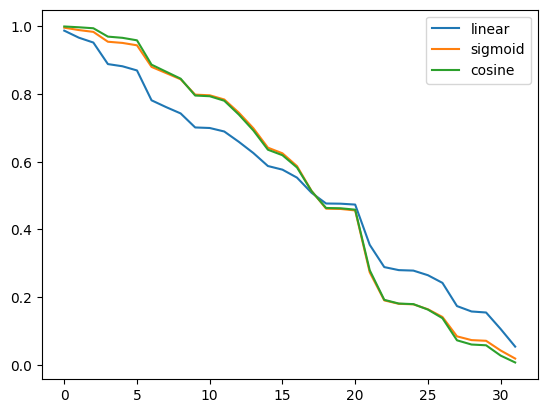

In [18]:
times = torch.zeros((32, )).float().uniform_(0,1)
sorted_times, _ = torch.sort(times, descending=False)
plt.plot(simple_linear_schedule(sorted_times), label="linear")
plt.plot(sigmoid_schedule(sorted_times), label="sigmoid")
plt.plot(cosine_schedule(sorted_times), label="cosine")
plt.legend()

# Cosine and sigmoid schedules are pretty similar, which in turn are not that
# different from the linear schedule in terms of overall pattern.
# The noise schedule plots make sense, in that I am plotting the sorted values of 
# randomly sampled time instances. In actual training, these are sampled randomly
# and used as such. We don't train models starting from "more noise" and gradually
# moving to low noised samples.
# However, during inference we do expect the models to understand this "quantity"
# of noise (hopefully from training) such that we can progressively remove small
# amounts of noise values and reach from a fully noise sample (1.) to a generated
# sample with no noise (0.). The schedule portrays that rough idea. 
# This is my interpretation and can well be wrong/misguided.

In [19]:
def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        # num_diffusion_timesteps = 2000
        t1 = i / num_diffusion_timesteps
        # 1 / 2000
        t2 = (i + 1) / num_diffusion_timesteps
        # 2 / 2000
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return 1 - np.array(betas)
    
def linear_schedule_text(num_diffusion_timesteps):
    scale = 1000 / num_diffusion_timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return 1- np.linspace(
        beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
    )
def cosine_schedule_text(num_diffusion_timesteps):
    return betas_for_alpha_bar(
        num_diffusion_timesteps,
        lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
    )

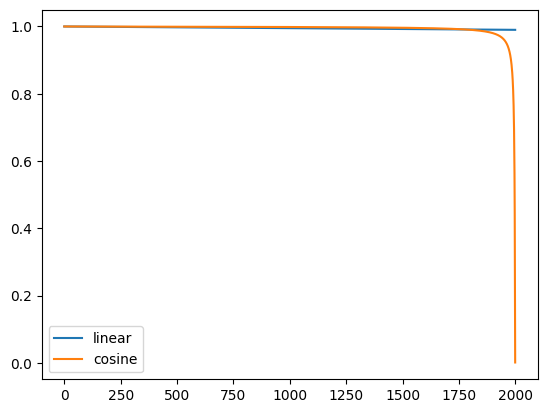

In [20]:
plt.plot(linear_schedule_text(2000), label="linear")
plt.plot(cosine_schedule_text(2000), label="cosine")
# plt.plot(cosine_schedule(sorted_times), label="cosine")
plt.legend()

In [23]:
class TextGaussianDiffusion(nn.Module):
    def __init__(self, alphas, model, num_timesteps, latent_conditioning_prob):
        
        super().__init__()
        self.model = model
        self.num_timesteps = num_timesteps
        self.latent_conditioning_prob = latent_conditioning_prob
        self.initialize_diffusion_params(alphas)

    def initialize_diffusion_params(self, alphas):
        
        self.alphas_cumprod = torch.cumprod(alphas, dim=0)
        # ā_t = a0*a1...*a_t
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1]), self.alphas_cumprod[:-1]])
        # ā_t-1 = a0*a1...*a_t-1
        self.alphas_cumprod_next = torch.cat([self.alphas_cumprod[1:], torch.tensor([1])])
        # ā_t+1 = a0*a1...a_t*a_t+1
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        # /ā_t
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1-self.alphas_cumprod)
        # /(1-ā_t)
        self.log_one_minus_alphas_cumprod = torch.log(1-self.alphas_cumprod)
        # log(1-ā_t)

        self.gt_posterior_variance = (1 - alphas) * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)
        # (1-a)(1-ā_t-1)/(1-ā_t)

        self.posterior_mean_coeff_xt = self.sqrt_alphas_cumprod * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)
        # /ā_t*(1-ā_t-1)/(1-ā_t)
        self.posterior_mean_coeff_x0 = torch.sqrt(self.alphas_cumprod_prev) * (1 - alphas) / (1 - self.alphas_cumprod)
        # /ā_t-1*(1-a)/(1-ā_t)

    def _index_noise_schedule(self, arr, timesteps, broadcast_shape):
        res = arr[timesteps].float()
        while len(res.shape) < len(broadcast_shape):
            res = res[..., None]
        return res.expand(broadcast_shape)

    def get_x0(self, mean):
        std_coeff = self._index_noise_schedule(
            arr=self.sqrt_one_minus_alphas_cumprod,
            timesteps=torch.tensor([0]),
            broadcast_shape=mean.shape
        )
        noise = torch.randn_like(mean)
        return mean + noise * std_coeff

    def get_xt(self, x0, t):
        noise = torch.randn_like(x0)
        mean_coeff = self._index_noise_schedule(
            arr=self.sqrt_alphas_cumprod,
            timesteps=t,
            broadcast_shape=x0.shape
        )
        std_coeff = self._index_noise_schedule(
            arr=self.sqrt_one_minus_alphas_cumprod,
            timesteps=t,
            broadcast_shape=x0.shape
        )
        return mean_coeff * x0 + std_coeff * noise

    def get_rounding_loss(self, logits, input_ids):
        # xt = [bs, seq_len, emb_dim]
        # logits = [bs, seq_len, vocab_size]
        # input_ids = [bs, seq_len]
        
        loss_fn = torch.nn.CrossEntropyLoss(reduction="none")
        nll = loss_fn(logits.view(-1, logits.shape[-1]), input_ids.view(-1)).view(input_ids.shape)
        # [bs, seq_len]
        return nll.mean(dim=-1)
        

    def mean_flat(self, tensor):
        """
        Take the mean over all non-batch dimensions.
        """
        return tensor.mean(dim=list(range(1, len(tensor.shape))))

    def forward(self, x, time):
        # x = input_ids = [bs, seq_len]
        # time = [bs]
        x_start_mean = self.model.interface_embedding(x)
        # [bs, seq_len, emb_dim]
        
        x0 = self.get_x0(x_start_mean)
        # [bs, seq_len, emb_dim]
        
        xt = self.get_xt(x0, time)
        zt_ = None # latent estimates

        if random() < self.latent_conditioning_prob:
            with torch.no_grad():
                x0_, _, zt_ = self.model(xt, time, None, None, None)
                zt_ = zt_.detach() # stop gradient on latent estimate
                # [bs, num_latents, latent_dim]

        x0_pred, logits, _ = self.model(xt, time, zt_, None, None)
        # x0_pred = [bs, seq_len, emb_dim]
        # logits = [bs, seq_len, vocab_size]
        
        mse_loss = self.mean_flat((x0_pred - x0) ** 2)
        # [bs]

        t0_loss = self.mean_flat((x0_pred - x_start_mean) ** 2)
        t0_mask = (time == 0)
        mse_loss = torch.where(t0_mask, t0_loss, mse_loss)
        # [bs]

        gt_posterior_mean = self._index_noise_schedule(
            arr=self.alphas_cumprod, 
            timesteps=torch.tensor([self.num_timesteps - 1]),
            broadcast_shape=x0.shape
        ) * x0
        tT_loss = self.mean_flat(gt_posterior_mean ** 2)
        # [bs]

        rounding_loss = self.get_rounding_loss(logits, x)
        # [bs]

        loss = mse_loss + tT_loss + rounding_loss
        # [bs]
    
        return loss

In [24]:
def test_diffusion_module():
    config = Config(num_heads=4,head_dim=32,time_dim=1024,attn_dropout=0.4,mult_factor=4,input_norm=True,context_norm=True,qk_norm=True)   
    rin = RIN(config,interface_dim=256,num_rin_blocks=4,num_latent_attn_layers=4,vocab_size=1000,interface_emb_dim=256,
              latent_dim=512,num_latents=128,learned_sinusoidal_dim=16,latent_token_time_cond=False)
    diffusion = TextGaussianDiffusion(torch.randn(100), rin, 100, 0.4)
    input_tokens = torch.ones(32, 128).long()
    time = torch.ones(32).long()
    loss = diffusion(input_tokens, time)
    assert loss.shape == torch.randn(32).shape
    assert type(loss.mean().detach().tolist()) ==  float

test_diffusion_module()

In [25]:
# TODO: 
# Understand diffusion lm codebase (revise), mainly how they process input and output
#  if the same noise term is multiplied by the entire sample or the entire batch of samples- 
    # yes, noise value sampled at particular t, multiplied by 1 ex
#  how the noised sample is calculated. I think the rin image codebase calculates x_t incorrectly. diffusion lm does it correctly -
    # makes more sense than rin
#  the goal is to now combine diffusion lm at input and output level with the processing of rin
#  self conditioning needs to be checked later (also if input self conditioning + latent self conditioning both are needed)
#  understand how the recurrence is introduced by detaching gradients from first set of latents (optional)
#  tokenization scheme
#  handle position embedding for interface tokens
#  handle time embeddings
# load e2e stories dataset and check other datasets that can be used from the diffusionLM paper
# Consider this only from a diffusion model pov. Not a transformer variant or anything else.
# Check how time information is passed: is it given to both latent & interface or just latents.

In [179]:
l = [1,2,3]
l[:None]

[1, 2, 3]

In [183]:
class WikiTextDataset(Dataset):
    def __init__(self, split, seq_len, partition=None):
        self.seq_len = seq_len
        self.dataset = load_dataset("wikitext", name="wikitext-2-raw-v1", split=split)
        self.tokenizer = AutoTokenizer.from_pretrained("gpt2")
        examples = self.preprocess()
        self.examples = examples[:partition]
    
    def preprocess(self):
        dataset = [text for text in self.dataset["text"] if text.strip()]
        dataset = [text.replace('\n', ' ').strip() for text in dataset]
        joint_dataset = " ".join([item for item in dataset])
        tokens = self.tokenizer(joint_dataset)
        all_input_ids = tokens.input_ids
        
        examples = []
        seq_len = self.seq_len
        for i in range(0, len(all_input_ids), seq_len-1):
            if i + (seq_len-1) > len(all_input_ids):
                break
            ex = all_input_ids[i:i+seq_len-1]
            ex.append(self.tokenizer.eos_token_id)
            assert len(ex) == seq_len #or len(ex) == len(all_input_ids) - (len(all_input_ids) // (seq_len-1))*(seq_len-1) + 1
            examples.append(ex)
        return examples
            
    def __len__(self):
        return len(self.examples)
        
    def __getitem__(self, idx):
        return torch.tensor(self.examples[idx], dtype=torch.long)


In [184]:
def test_dataset():
    seq_len = 128
    train_dataset = WikiTextDataset("train", seq_len)
    assert train_dataset[0].shape == torch.randn(seq_len).shape
    train_loader = DataLoader(train_dataset, batch_size=32)
    a = next(iter(train_loader))
    assert a.shape == torch.randn(32, seq_len).shape
    
test_dataset()

Token indices sequence length is longer than the specified maximum sequence length for this model (2344347 > 1024). Running this sequence through the model will result in indexing errors


In [185]:
train_dataset = WikiTextDataset("train", seq_len, 4)
train_loader = DataLoader(train_dataset, batch_size=1)

Token indices sequence length is longer than the specified maximum sequence length for this model (2344347 > 1024). Running this sequence through the model will result in indexing errors


In [177]:
config = Config(num_heads=4,head_dim=32,time_dim=1024,attn_dropout=0.4,mult_factor=4,input_norm=True,context_norm=True,qk_norm=True)   
rin = RIN(config,interface_dim=256,num_rin_blocks=4,num_latent_attn_layers=4,vocab_size=1000,interface_emb_dim=256,
          latent_dim=512,num_latents=128,learned_sinusoidal_dim=16,latent_token_time_cond=False)
model = TextGaussianDiffusion(torch.randn(100), rin, 100, 0.4)
optimizer = torch.optim.AdamW(model.parameters())
    

In [188]:
running_loss = 0
for idx, input_ids in enumerate(train_loader):
    model.train()
    optimizer.zero_grad()
    times = torch.zeros((input_ids.shape[0], )).float().uniform_(0,1)
    loss = model(input_ids, times)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
total_loss = running_loss / len(train_loader)
    

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])